In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import pywt  # Added for wavelet transforms
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin  # For custom transformer class

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

sys.path.append('../models')
from wavelet import WaveletTransformer, extract_wavelet_features

# Training simple decoders cross subject
Compared to the within subject accuracy, the simple decoders are **terrible** at classifying hands vs. feet predicting at chance levels.



### Loading data and preprocessing
Using all runs for motor imagery task classifying hands vs. feet on first 50 subjects. 

In [4]:

models_dir = '../models/trained/'

print(__doc__)


tmin, tmax = -1.0, 4.0
subjects = range(1, 51)  # Training on the first 50 subjects
runs = [6, 10, 14]  # Motor imagery: hands vs feet
raws = []

for subject in subjects:
    try:
        # Attempt to load the data for the current subject
        raw_fnames = eegbci.load_data(subject, runs)
        # For each subject, load their raw data and append to the 'raws' list
        raws.extend([read_raw_edf(f, preload=True) for f in raw_fnames])
        print(f"Successfully processed subject {subject}.")
    except Exception as e:
        # If an error occurs, skip to the next subject
        print(f"Error processing subject {subject}: {e}. Skipping to next subject.")
        continue

raw = concatenate_raws(raws)

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Successfully processed subject 1.
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R06.edf...
EDF file detected
Setting channe

In [5]:
# Preprocessing
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) 
event_id = dict(hands=2, feet=3)


epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
#epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Filtering raw data in 150 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2250 events and 801 original time points ...
7 bad epochs dropped


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


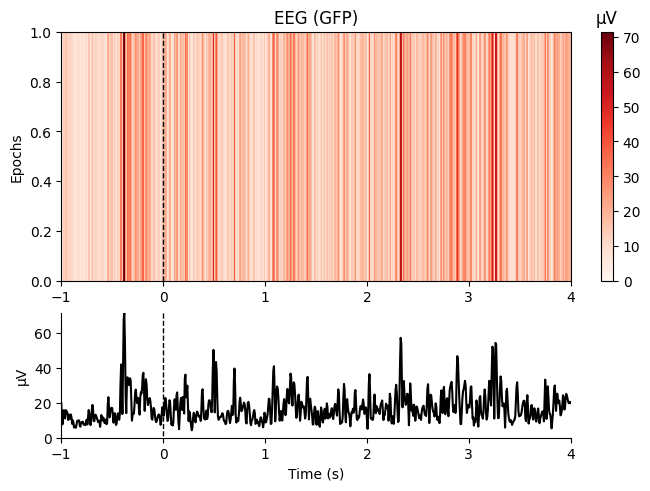

[<Figure size 640x480 with 3 Axes>]

In [6]:
epochs[0].plot_image()

### Feature decoding and classification

In [7]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
#epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)

In [8]:
# CSP + LDA

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Building Pipeline
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_lda.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=None)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
#csp.fit_transform(epochs_data, labels)
#csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 64 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 64 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Esti

Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


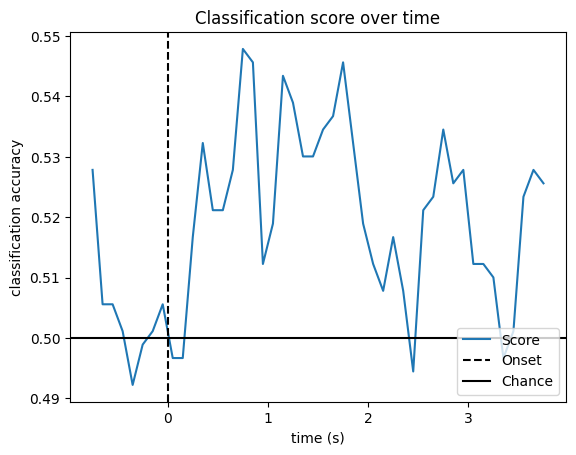

In [9]:
sfreq = raw.info["sfreq"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)

# Transform data using CSP and fit LDA classifier as before
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, X_test.shape[2] - w_length, w_step)

scores_windows = []

# Transform training data once, since we're not using cross-validation loop here
X_train_transformed = csp.fit_transform(X_train, y_train)

# Fit classifier to transformed training data
lda.fit(X_train_transformed, y_train)

# Running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    this_window = X_test[:, :, n : (n + w_length)]
    X_test_transformed = csp.transform(this_window)
    score_this_window.append(lda.score(X_test_transformed, y_test))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()


In [10]:
# CSP + Logistic Regression

lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_logistic.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + Logistic Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))



Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
CSP + Logistic Regression Classification accuracy: 0.516704 / Chance level: 0.512249


In [11]:
# Wavelet + SVM

wavelet_transformer = WaveletTransformer(sfreq)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'wavelet_svm.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("Wavelet + SVM Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))


Wavelet + SVM Regression Classification accuracy: 0.512249 / Chance level: 0.512249


In [12]:
# CSP + SVM


csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])

# Fitting the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_svm.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + SVM Classification accuracy: %f / Chance level: %f" % (score, class_balance))

Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
CSP + SVM Classification accuracy: 0.516704 / Chance level: 0.512249
